**stacking** is to learn several different weak learners and combine them by training a meta-model to output predictions based on the multiple predictions returned by these weak models.

So, we need to define two things in order to build our stacking model: the L learners we want to fit and the meta-model that combines them.


For example, for a classification problem, we can choose as weak learners a KNN classifier, a logistic regression and a SVM, and decide to learn a neural network as meta-model. Then, the neural network will take as inputs the outputs of our three weak learners and will learn to return final predictions based on it.

**Stacking:**

1. We split the training data into K-folds just like K-fold cross-validation.

2. A base model is fitted on the K-1 parts and predictions are made for Kth part.

![alt text](https://media.geeksforgeeks.org/wp-content/uploads/20190515104539/stackingWork.png)

3. We do for each part of the training data.

4. The base model is then fitted on the whole train data set to calculate its performance on the test set.

5. We repeat the last 3 steps for other base models.

![alt text](https://burakhimmetoglu.files.wordpress.com/2016/12/workflow.png?w=1140)

6. Predictions from the train set are used as features for the second level model.

7. Second level model is used to make a prediction on the test set.

In [43]:
#importing librabries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_boston
import warnings
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, BaggingRegressor, RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [44]:
# Load data
boston = datasets.load_boston()
print(boston.data.shape, boston.target.shape)
print(boston.feature_names)

(506, 13) (506,)
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [45]:
print(boston.keys())

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])


In [46]:
data = pd.DataFrame(boston.data,columns=boston.feature_names)
data = pd.concat([data,pd.Series(boston.target,name='MEDV')],axis=1)
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [47]:
# Data Dictionary
print(datasets.load_boston().DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [48]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [49]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=123)

**Applying Linear regression**

In [50]:
# Apply Linear Regression Model as Base Model
lr = LinearRegression()
pred_lr = lr.fit(xtrain, ytrain).predict(xtest)

# Checking Model Metrics
from sklearn.metrics import r2_score, mean_squared_error
print("R2 Score: ", r2_score(ytest, pred_lr))
print("RMSE: ", np.sqrt(mean_squared_error(ytest, pred_lr)))

R2 Score:  0.65924665103541
RMSE:  5.309659665032168


**Checking accuracy for different -different base models**

In [51]:
# Get a List of Models as Base Models
def base_models():
  models = dict()
  models['lr'] = LinearRegression()
  models["Ridge"] = Ridge()
  models["Lasso"] = Lasso()
  models["Tree"] = DecisionTreeRegressor()
  models["Random Forest"] = RandomForestRegressor()
  models["Bagging"] = BaggingRegressor()
  models["GBM"] = GradientBoostingRegressor()
  return models

In [52]:
# Now we will apply K Fold Cross Validation. We will now create a evaluate function with Repeated Stratified K Fold
# And Capture the Cross Val Score
from sklearn.model_selection import RepeatedKFold
from matplotlib import pyplot

# Function to evaluate the list of models
def eval_models(model):
  cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = -cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, 
                            error_score='raise')
  return scores

In [53]:
# get the models to evaluate
models = base_models()
models

{'Bagging': BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False),
 'GBM': GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                           init=None, learning_rate=0.1, loss='ls', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0, warm_start=False),
 'Lasso': Lasso(alpha=1.0, copy_X=True, 

In [54]:
# evaluate the models and store results
results, names = list(), list() 

for name, model in models.items():
  scores = eval_models(model)
  results.append(scores)
  names.append(name)
  print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))

>lr 3.391 (0.530)
>Ridge 3.382 (0.519)
>Lasso 3.711 (0.549)
>Tree 2.921 (0.608)
>Random Forest 2.199 (0.351)
>Bagging 2.316 (0.372)
>GBM 2.087 (0.276)


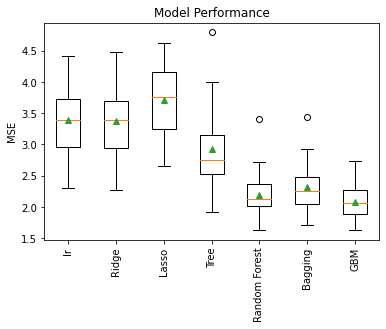

In [55]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.xticks(rotation = 90)
pyplot.ylabel("MSE")
pyplot.title("Model Performance")
pyplot.show()

Preparing stacking with base models as ('tree','RF','XGB','Bagging') and meta learner as 'LGBM

In [56]:
# get a stacking ensemble of models
def get_stacking():
	# define the base models
  level0 = list()
  level0.append(('Tree', DecisionTreeRegressor()))
  level0.append(('RF', RandomForestRegressor()))
  level0.append(('XGB', XGBRegressor()))
  level0.append(('Bagging', BaggingRegressor()))
	# define meta learner model
  level1 = LGBMRegressor()
	# define the stacking ensemble
  model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
  return model

In [57]:
get_stacking()

StackingRegressor(cv=5,
                  estimators=[('Tree',
                               DecisionTreeRegressor(ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=None,
                                                     max_features=None,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     presort='deprecated',
                                                     random_state=None,
                                                 

In [58]:
def base_models():
  models = dict()
  models["Tree"] = DecisionTreeRegressor()
  models["Random Forest"] = RandomForestRegressor()
  models["Bagging"] = BaggingRegressor()
  models["XGB"] = XGBRegressor()
  models["Stacked Model"] = get_stacking()
  return models

In [59]:
base_models()

{'Bagging': BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False),
 'Random Forest': RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False),
 'Stacked Model': StackingRegressor(cv=5,
                   estimators=[('Tree',
                                DecisionTreeRegressor(ccp_alpha=0.0,
                                                  

In [60]:
# Function to evaluate the list of models
def eval_models(model):
  cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = -cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, 
                            error_score='raise')
  return scores

In [61]:
# get the models to evaluate
models = base_models()
# evaluate the models and store results
results, names = list(), list() 

In [62]:
for name, model in models.items():
  scores = eval_models(model)
  results.append(scores)
  names.append(name)
  print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))

>Tree 2.936 (0.520)
>Random Forest 2.202 (0.341)
>Bagging 2.313 (0.365)
>XGB 2.146 (0.328)
>Stacked Model 2.727 (0.383)


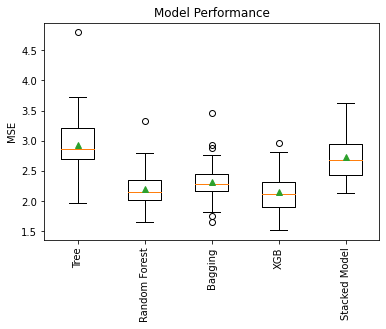

In [63]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.xticks(rotation = 90)
pyplot.ylabel("MSE")
pyplot.title("Model Performance")
pyplot.show()

In [64]:
# Lets apply on Train and Test Split
level0 = list()
level0.append(('Tree', DecisionTreeRegressor()))
level0.append(('RF', RandomForestRegressor()))
level0.append(('GBM', GradientBoostingRegressor()))
level0.append(('Bagging', BaggingRegressor()))
level0.append(("XGB", XGBRegressor()))

In [65]:
level0

[('Tree', DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best')),
 ('RF', RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        max_samples=None, min_impurity_decrease=0.0,
                        min_impurity_split=None, min_samples_leaf=1,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        n_estimators=100, n_jobs=None, oob_score=False,
                        random_state=None, verbose=0, warm_start=False)),
 ('GBM',
  GradientBoostingRegressor(alpha=0.9, ccp_alpha=

In [66]:
level1 = LGBMRegressor()
model = StackingRegressor(estimators=level0, final_estimator=level1, cv=10)

In [67]:
# Making Predictions on Train & Test
stacked_pred = model.fit(xtrain, ytrain).predict(xtest)

[15:03:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:03:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:03:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:03:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:03:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:03:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:03:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:03:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [68]:
# Checking Model Metrics
print(r2_score(ytest, stacked_pred))
print(np.sqrt(mean_squared_error(ytest, stacked_pred)))

0.7918968533311197
4.1494061089674785
